# 投球タイプ分類器（Pitch Identification Model）

本プロジェクトは、pybaseballライブラリを用いてMLBのStatcastデータを取得し、投球の物理的な特徴量（球速、回転、変化量など）からその球種（pitch_type）を分類する機械学習モデルを構築します。


## 目次
0. ライブラリ・データ読み込み
1. データの概観・分析・前処理
2. ベースラインモデルの構築
3. 特徴量エンジニアリング
4. 様々なモデルの構築・調整
5. モデルのアンサンブリング
6. 予測の出力・評価
7. 結果の分析・Error Analysis


## 0. ライブラリ・データ読み込み

まず初めに使用するライブラリを読み込みます。


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# データ取得ライブラリ
from pybaseball import statcast

# 機械学習モデル
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
import lightgbm as lgb
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier

# 警告非表示
import warnings
warnings.filterwarnings('ignore')


次にpybaseball.statcast()を用いて、特定の期間の投球データを取得します。

注意：全期間を取得するとデータ量が膨大になるため、期間を絞るか、特定の投手でテストすることを推奨します。


In [2]:
# 例：2023年シーズンのデータを取得
# (注意：全期間を取得するとデータ量が膨大になるため、期間を絞るか、特定の投手でテストする)
print("Fetching Statcast data...")
data = statcast(start_dt='2023-04-01', end_dt='2023-10-01')
print("Data fetched.")
print(f"Data shape: {data.shape}")


Fetching Statcast data...
This is a large query, it may take a moment to complete


100%|██████████| 184/184 [01:02<00:00,  2.94it/s]


Data fetched.
Data shape: (714703, 118)


## 1. データの概観・分析・前処理

### 1.1 データの概観

データのサイズを確認します。


In [3]:
print(f'データ数は{data.shape[0]}、変数は{data.shape[1]}種類です。')


データ数は714703、変数は118種類です。


In [4]:
# データの最初の数行を確認
data.head(10)


,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,...,batter_days_until_next_game,api_break_z_with_gravity,api_break_x_arm,api_break_x_batter_in,arm_angle,attack_angle,attack_direction,swing_path_tilt,intercept_ball_minus_batter_pos_x_inches,intercept_ball_minus_batter_pos_y_inches
2442,CH,2023-10-01,89.0,-2.8,5.59,"Robertson, Nick",677008,687798,field_out,hit_into_play,...,<NA>,2.55,1.53,-1.53,31.7,1.676715,-1.896554,41.830979,30.714944,26.41202
2513,FF,2023-10-01,96.9,-2.4,5.9,"Robertson, Nick",677008,687798,NaN,foul,...,<NA>,1.09,0.76,-0.76,47.4,8.715532,3.692542,40.551342,33.656454,26.020583
2607,CH,2023-10-01,90.0,-2.93,5.56,"Robertson, Nick",677008,687798,NaN,ball,...,<NA>,2.47,1.65,-1.65,30.3,<NA>,<NA>,<NA>,<NA>,<NA>
2705,ST,2023-10-01,82.2,-3.09,5.55,"Robertson, Nick",677008,687798,NaN,ball,...,<NA>,3.14,-1.43,1.43,28.9,<NA>,<NA>,<NA>,<NA>,<NA>
2817,CH,2023-10-01,89.2,-2.87,5.58,"Robertson, Nick",677008,687798,NaN,swinging_strike,...,<NA>,2.57,1.49,-1.49,34.3,20.169759,-7.584644,37.675911,44.236969,36.187039
2932,FF,2023-10-01,96.2,-2.37,5.96,"Robertson, Nick",677008,687798,NaN,swinging_strike,...,<NA>,1.08,0.71,-0.71,43.8,14.642472,4.79365,37.058134,27.45065,20.292713
2991,CH,2023-10-01,88.2,-2.86,5.51,"Robertson, Nick",602104,687798,strikeout,swinging_strike,...,6,2.51,1.45,1.45,31.8,12.675671,-25.318306,32.984103,29.051912,38.369551
3183,FF,2023-10-01,95.7,-2.4,5.8,"Robertson, Nick",602104,687798,NaN,foul,...,6,1.19,0.48,0.48,38.4,-3.690621,14.173457,27.01586,46.463475,19.285215
3307,ST,2023-10-01,79.4,-2.96,5.67,"Robertson, Nick",602104,687798,NaN,ball,...,6,3.82,-1.66,-1.66,32.4,<NA>,<NA>,<NA>,<NA>,<NA>
3439,ST,2023-10-01,82.9,-2.82,5.66,"Robertson, Nick",602104,687798,NaN,ball,...,6,3.29,-1.16,-1.16,32.8,<NA>,<NA>,<NA>,<NA>,<NA>


In [5]:
# 変数名の一覧を確認
data.columns.tolist()


['pitch_type',
 'game_date',
 'release_speed',
 'release_pos_x',
 'release_pos_z',
 'player_name',
 'batter',
 'pitcher',
 'events',
 'description',
 'spin_dir',
 'spin_rate_deprecated',
 'break_angle_deprecated',
 'break_length_deprecated',
 'zone',
 'des',
 'game_type',
 'stand',
 'p_throws',
 'home_team',
 'away_team',
 'type',
 'hit_location',
 'bb_type',
 'balls',
 'strikes',
 'game_year',
 'pfx_x',
 'pfx_z',
 'plate_x',
 'plate_z',
 'on_3b',
 'on_2b',
 'on_1b',
 'outs_when_up',
 'inning',
 'inning_topbot',
 'hc_x',
 'hc_y',
 'tfs_deprecated',
 'tfs_zulu_deprecated',
 'umpire',
 'sv_id',
 'vx0',
 'vy0',
 'vz0',
 'ax',
 'ay',
 'az',
 'sz_top',
 'sz_bot',
 'hit_distance_sc',
 'launch_speed',
 'launch_angle',
 'effective_speed',
 'release_spin_rate',
 'release_extension',
 'game_pk',
 'fielder_2',
 'fielder_3',
 'fielder_4',
 'fielder_5',
 'fielder_6',
 'fielder_7',
 'fielder_8',
 'fielder_9',
 'release_pos_y',
 'estimated_ba_using_speedangle',
 'estimated_woba_using_speedangle',
 'w

### 1.2 データの分析（EDA）

探索的データ分析（EDA）を行います。まず、必要な特徴量とターゲットが存在することを確認します。


In [6]:
# 必要な特徴量の確認
required_features = ['release_speed', 'release_spin_rate', 'spin_axis', 
                     'pfx_x', 'pfx_z', 'release_pos_x', 'release_pos_z', 'pitch_type']

# 存在する特徴量を確認
available_features = [feat for feat in required_features if feat in data.columns]
missing_features = [feat for feat in required_features if feat not in data.columns]

print("利用可能な特徴量:", available_features)
print("欠損している特徴量:", missing_features)

# 利用可能な特徴量のみを使用
if len(missing_features) > 0:
    print(f"\n警告: 以下の特徴量がデータに存在しません: {missing_features}")
    print("利用可能な特徴量のみを使用します。")


利用可能な特徴量: ['release_speed', 'release_spin_rate', 'spin_axis', 'pfx_x', 'pfx_z', 'release_pos_x', 'release_pos_z', 'pitch_type']
欠損している特徴量: []


In [7]:
# 欠損値の確認（利用可能な特徴量のみ）
print("欠損値の確認:")
if len(available_features) > 0:
    print(data[available_features].isnull().sum())
else:
    print("利用可能な特徴量がありません。")


欠損値の確認:
release_speed        2820
release_spin_rate    6779
spin_axis            6777
pfx_x                2822
pfx_z                2822
release_pos_x        2822
release_pos_z        2822
pitch_type           2983
dtype: int64


In [8]:
# ターゲット（pitch_type）の分析
if 'pitch_type' in data.columns:
    print("球種の内訳:")
    print(data['pitch_type'].value_counts())
    print("\n球種の割合:")
    print(data['pitch_type'].value_counts(normalize=True))
else:
    print("エラー: 'pitch_type'列がデータに存在しません。")


球種の内訳:
pitch_type
FF    228328
SL    114396
SI    110269
CH     77250
FC     56262
CU     47154
ST     41688
FS     15955
KC     14744
SV      2842
FA      1114
FO       778
EP       558
KN       192
SC        74
CS        70
PO        46
Name: count, dtype: int64

球種の割合:
pitch_type
FF    0.320812
SL    0.160732
SI    0.154933
CH    0.108540
FC    0.079051
CU    0.066254
ST    0.058574
FS    0.022418
KC    0.020716
SV    0.003993
FA    0.001565
FO    0.001093
EP    0.000784
KN    0.000270
SC    0.000104
CS    0.000098
PO    0.000065
Name: proportion, dtype: float64


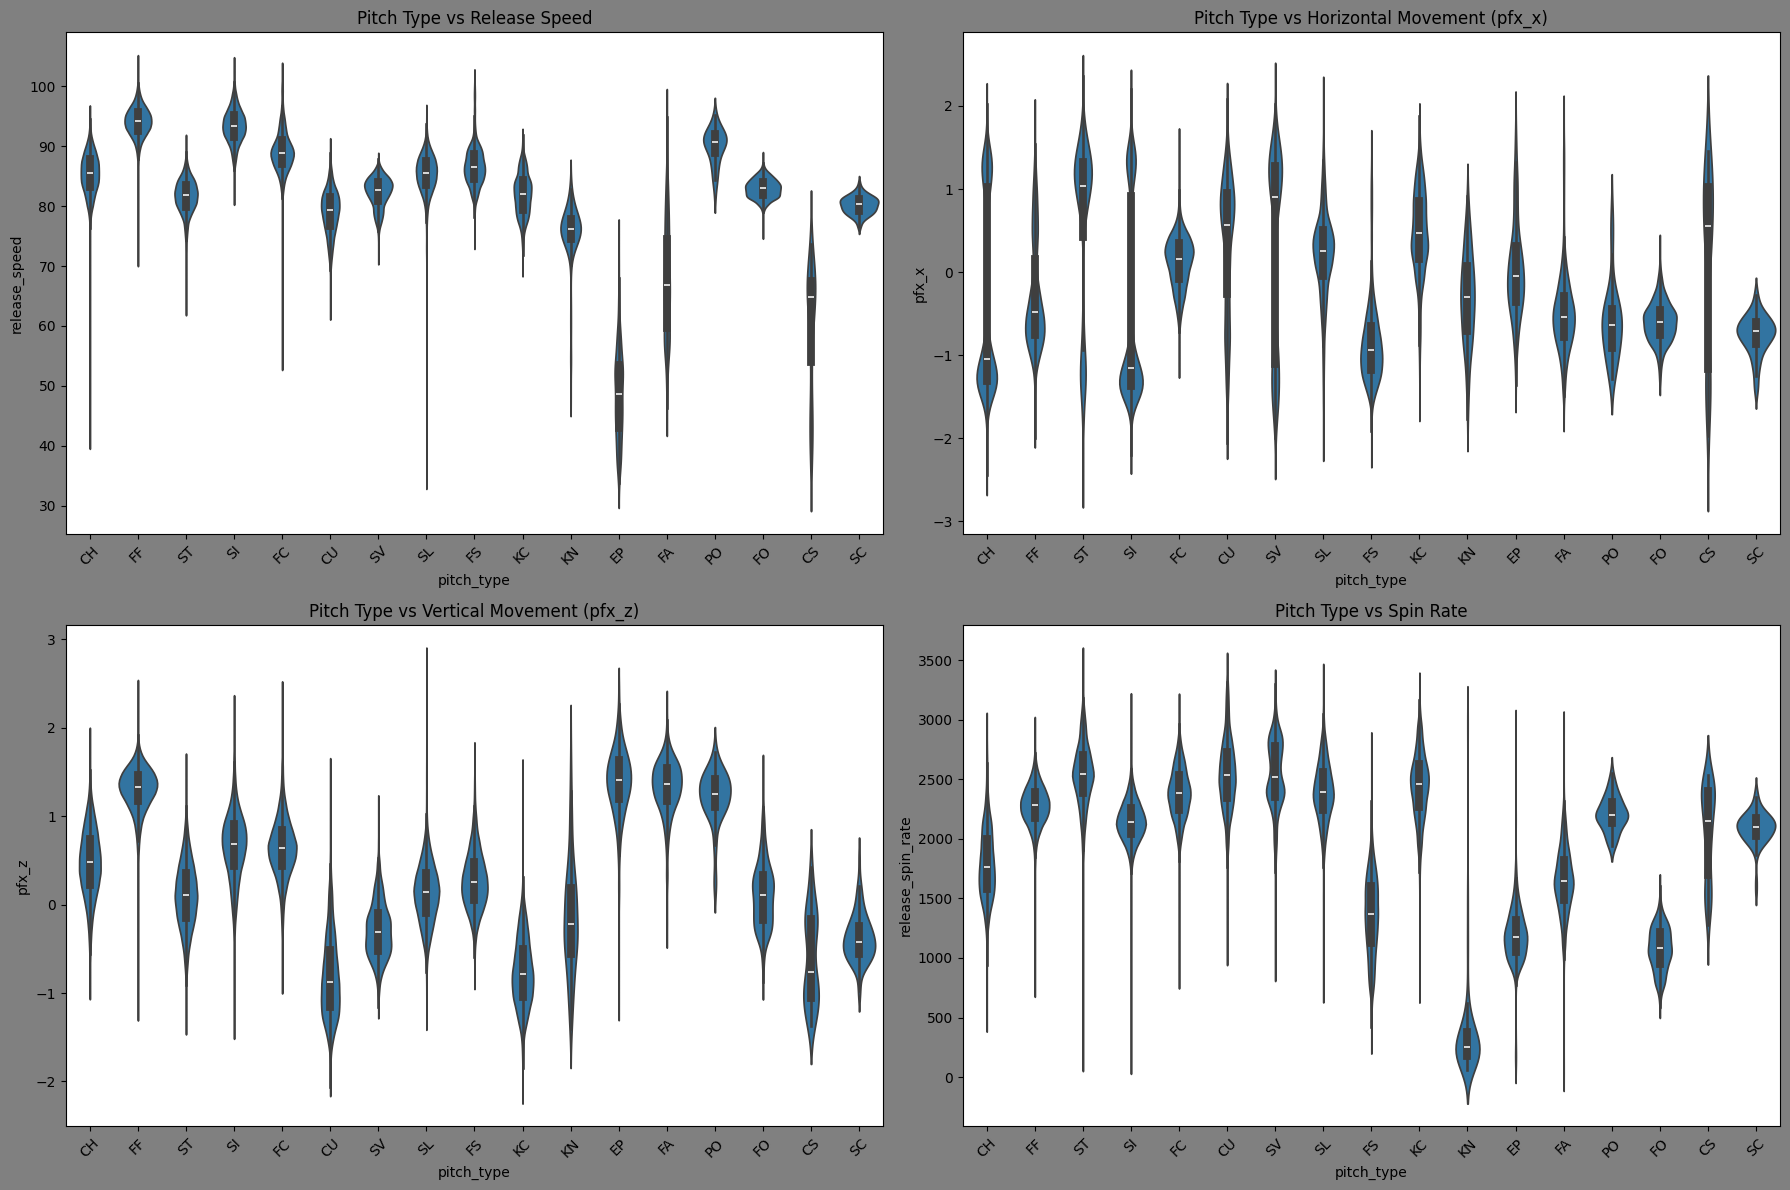

In [9]:
# 球種ごとの分布を可視化（バイオリン図）
# 利用可能な特徴量のみを使用
plot_features = []
if 'release_speed' in data.columns:
    plot_features.append(('release_speed', 'Release Speed'))
if 'pfx_x' in data.columns:
    plot_features.append(('pfx_x', 'Horizontal Movement (pfx_x)'))
if 'pfx_z' in data.columns:
    plot_features.append(('pfx_z', 'Vertical Movement (pfx_z)'))
if 'release_spin_rate' in data.columns:
    plot_features.append(('release_spin_rate', 'Spin Rate'))

if len(plot_features) > 0 and 'pitch_type' in data.columns:
    # データのコピーを作成してインデックスをリセット（重複インデックスの問題を回避）
    plot_data = data[['pitch_type'] + [feat for feat, _ in plot_features]].copy().reset_index(drop=True)
    
    n_plots = min(len(plot_features), 4)
    n_cols = 2
    n_rows = (n_plots + 1) // 2
    f, ax = plt.subplots(n_rows, n_cols, figsize=(18, 6*n_rows), facecolor='gray')
    if n_rows == 1:
        ax = ax.reshape(1, -1)
    
    for idx, (feat, title) in enumerate(plot_features[:4]):
        row = idx // n_cols
        col = idx % n_cols
        sns.violinplot(x="pitch_type", y=feat, data=plot_data, ax=ax[row, col])
        ax[row, col].set_title(f'Pitch Type vs {title}')
        ax[row, col].tick_params(axis='x', rotation=45)
    
    # 余ったサブプロットを非表示
    for idx in range(n_plots, n_rows * n_cols):
        row = idx // n_cols
        col = idx % n_cols
        ax[row, col].axis('off')
    
    plt.tight_layout()
    plt.show()
else:
    print("可視化に必要な特徴量が不足しています。")


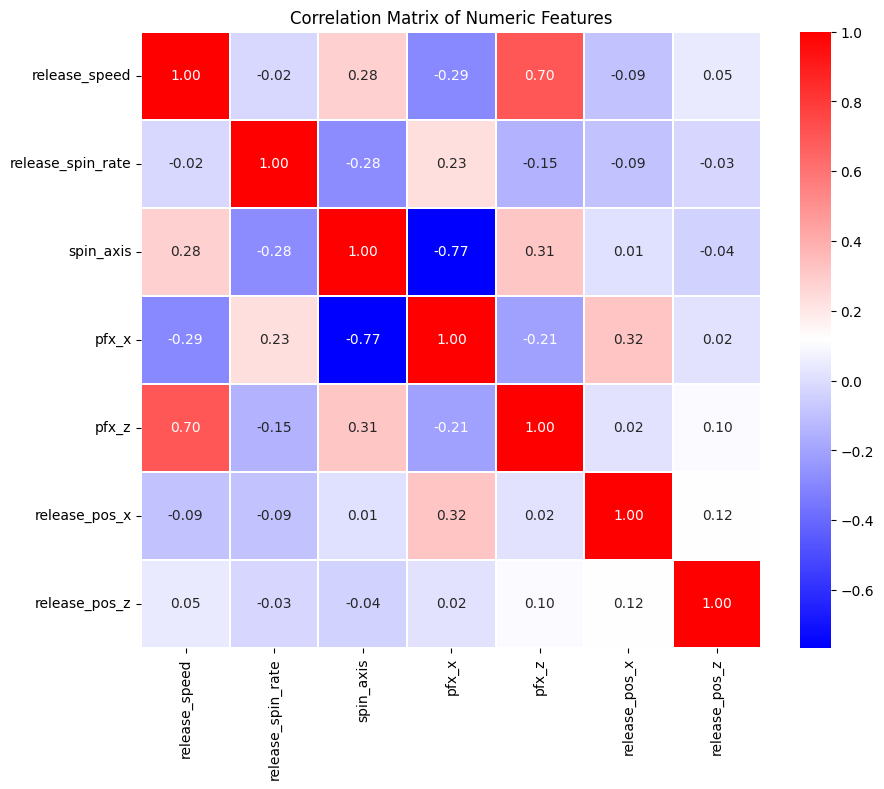

In [10]:
# 相関行列のヒートマップ
numeric_features = ['release_speed', 'release_spin_rate', 'spin_axis', 
                    'pfx_x', 'pfx_z', 'release_pos_x', 'release_pos_z']
# 存在する特徴量のみを使用
numeric_features_available = [feat for feat in numeric_features if feat in data.columns]

if len(numeric_features_available) > 0:
    df_numeric = data[numeric_features_available].select_dtypes(include=['number'])
    if len(df_numeric.columns) > 0:
        sns.heatmap(df_numeric.corr(), annot=True, cmap='bwr', linewidths=0.2, fmt='.2f')
        fig = plt.gcf()
        fig.set_size_inches(10, 8)
        plt.title('Correlation Matrix of Numeric Features')
        plt.show()
    else:
        print("数値型の特徴量がありません。")
else:
    print("相関行列を作成するための特徴量が不足しています。")


### 1.3 データの前処理

機械学習モデルが学習できるようにデータの前処理を行います。


In [11]:
# データのコピーを作成
df = data.copy()

# 必要な特徴量を選択（存在する特徴量のみ）
feature_cols = ['release_speed', 'release_spin_rate', 'spin_axis', 
                'pfx_x', 'pfx_z', 'release_pos_x', 'release_pos_z']
feature_cols = [feat for feat in feature_cols if feat in df.columns]

if len(feature_cols) == 0:
    raise ValueError("必要な特徴量がデータに存在しません。")

print(f"使用する特徴量: {feature_cols}")

# 欠損値の処理：欠損が多い行を削除
print("前処理前のデータ数:", len(df))
if 'pitch_type' in df.columns:
    df = df.dropna(subset=feature_cols + ['pitch_type'])
else:
    raise ValueError("'pitch_type'列がデータに存在しません。")
print("前処理後のデータ数:", len(df))

# 欠損値の確認
print("\n欠損値の確認:")
print(df[feature_cols + ['pitch_type']].isnull().sum())


使用する特徴量: ['release_speed', 'release_spin_rate', 'spin_axis', 'pfx_x', 'pfx_z', 'release_pos_x', 'release_pos_z']
前処理前のデータ数: 714703
前処理後のデータ数: 707792

欠損値の確認:
release_speed        0
release_spin_rate    0
spin_axis            0
pfx_x                0
pfx_z                0
release_pos_x        0
release_pos_z        0
pitch_type           0
dtype: int64


In [12]:
# 投球数が少ない球種を除外または「Others」にまとめる
pitch_counts = df['pitch_type'].value_counts()
print("各球種の投球数:")
print(pitch_counts)

# 投球数が100未満の球種を「Others」にまとめる（閾値は調整可能）
min_pitches = 100
rare_pitches = pitch_counts[pitch_counts < min_pitches].index.tolist()
print(f"\n投球数が{min_pitches}未満の球種（Othersにまとめる）: {rare_pitches}")

if len(rare_pitches) > 0:
    df['pitch_type'] = df['pitch_type'].replace(rare_pitches, 'Others')
    print("\n処理後の球種の内訳:")
    print(df['pitch_type'].value_counts())


各球種の投球数:
pitch_type
FF    227319
SL    113741
SI    109410
CH     76883
FC     55985
CU     46914
ST     41351
FS     15864
KC     14699
SV      2810
FA      1113
FO       766
EP       557
KN       192
SC        74
CS        68
PO        46
Name: count, dtype: int64

投球数が100未満の球種（Othersにまとめる）: ['SC', 'CS', 'PO']

処理後の球種の内訳:
pitch_type
FF        227319
SL        113741
SI        109410
CH         76883
FC         55985
CU         46914
ST         41351
FS         15864
KC         14699
SV          2810
FA          1113
FO           766
EP           557
KN           192
Others       188
Name: count, dtype: int64


In [13]:
# 特徴量（X）とターゲット（Y）を抽出
X = df[feature_cols].values
y = df['pitch_type'].values

# ターゲットのエンコーディング（LabelEncoder）
le = LabelEncoder()
y_encoded = le.fit_transform(y)

print("特徴量の形状:", X.shape)
print("ターゲットの形状:", y_encoded.shape)
print("球種のクラス数:", len(le.classes_))
print("球種のクラス:", le.classes_)


特徴量の形状: (707792, 7)
ターゲットの形状: (707792,)
球種のクラス数: 15
球種のクラス: ['CH' 'CU' 'EP' 'FA' 'FC' 'FF' 'FO' 'FS' 'KC' 'KN' 'Others' 'SI' 'SL' 'ST'
 'SV']


In [14]:
# データの分割（訓練データと検証データ）
X_train, X_valid, y_train, y_valid = train_test_split(X, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded)

print(f"訓練データ数: {X_train.shape[0]}")
print(f"検証データ数: {X_valid.shape[0]}")


訓練データ数: 495454
検証データ数: 212338


## 2. ベースラインモデルの構築

まずは単純なモデルで、現状のデータと前処理でどの程度の精度が出るかを確認します。


In [15]:
# ベースラインモデル：全特徴量を使用
rfc_baseline = RandomForestClassifier(max_depth=10, min_samples_leaf=1, n_estimators=100, n_jobs=-1, random_state=42)
rfc_baseline.fit(X_train, y_train)

print('ベースラインモデル（全特徴量）')
print('Train Score: {}'.format(round(rfc_baseline.score(X_train, y_train), 3)))
print('Valid Score: {}'.format(round(rfc_baseline.score(X_valid, y_valid), 3)))


ベースラインモデル（全特徴量）
Train Score: 0.849
Valid Score: 0.845


## 3. 特徴量エンジニアリング

ドメイン知識（野球の知識）に基づき、よりモデルの精度向上に寄与する特徴量を作成します。


In [16]:
# 特徴量エンジニアリング用のデータフレームを作成
df_fe = df.copy()

# 1. 回転軸の変換（spin_axisは循環的な特徴量なので、sinとcosに変換）
if 'spin_axis' in df_fe.columns:
    df_fe['spin_axis_sin'] = np.sin(np.radians(df_fe['spin_axis']))
    df_fe['spin_axis_cos'] = np.cos(np.radians(df_fe['spin_axis']))
    print("spin_axis_sin と spin_axis_cos を作成しました。")
else:
    print("警告: 'spin_axis'が存在しないため、spin_axis_sin と spin_axis_cos をスキップします。")

# 2. 変化量の合成（水平変化量と垂直変化量から総変化量を計算）
if 'pfx_x' in df_fe.columns and 'pfx_z' in df_fe.columns:
    df_fe['total_movement'] = np.sqrt(df_fe['pfx_x']**2 + df_fe['pfx_z']**2)
    print("total_movement を作成しました。")
else:
    print("警告: 'pfx_x' または 'pfx_z' が存在しないため、total_movement をスキップします。")

# 3. スピン効率（推定）：球速に対する回転数の比率
if 'release_spin_rate' in df_fe.columns and 'release_speed' in df_fe.columns:
    # ゼロ除算を防ぐため、release_speedが0の場合はNaNにする
    df_fe['spin_per_mph'] = df_fe['release_spin_rate'] / df_fe['release_speed'].replace(0, np.nan)
    print("spin_per_mph を作成しました。")
else:
    print("警告: 'release_spin_rate' または 'release_speed' が存在しないため、spin_per_mph をスキップします。")

# 新しい特徴量を確認
new_feature_list = []
if 'spin_axis_sin' in df_fe.columns:
    new_feature_list.append('spin_axis_sin')
if 'spin_axis_cos' in df_fe.columns:
    new_feature_list.append('spin_axis_cos')
if 'total_movement' in df_fe.columns:
    new_feature_list.append('total_movement')
if 'spin_per_mph' in df_fe.columns:
    new_feature_list.append('spin_per_mph')

if len(new_feature_list) > 0:
    print("\n新しく作成した特徴量:")
    print(df_fe[new_feature_list].head())
    print("\n欠損値の確認:")
    print(df_fe[new_feature_list].isnull().sum())
else:
    print("\n新しく作成された特徴量はありません。")


spin_axis_sin と spin_axis_cos を作成しました。
total_movement を作成しました。
spin_per_mph を作成しました。

新しく作成した特徴量:
      spin_axis_sin  spin_axis_cos  total_movement  spin_per_mph
2442      -0.939693       -0.34202        1.565184     19.134831
2513      -0.515038      -0.857167        1.557947     22.218782
2607      -0.939693       -0.34202        1.688816     18.866667
2705       0.848048       0.529919        1.457155     33.892944
2817       -0.97437      -0.224951        1.521907     17.813901

欠損値の確認:
spin_axis_sin     0
spin_axis_cos     0
total_movement    0
spin_per_mph      0
dtype: int64


In [17]:
# 特徴量エンジニアリング後の特徴量リスト
new_features = ['spin_axis_sin', 'spin_axis_cos', 'total_movement', 'spin_per_mph']
feature_cols_fe = feature_cols + [feat for feat in new_features if feat in df_fe.columns]

# 欠損値の処理
df_fe = df_fe.dropna(subset=feature_cols_fe + ['pitch_type'])

# 特徴量とターゲットを抽出
X_fe = df_fe[feature_cols_fe].values
y_fe = df_fe['pitch_type'].values

# ターゲットのエンコーディング（新しいLabelEncoderを作成してfit_transformを使用）
# 特徴量エンジニアリング後のデータでも同じ球種が含まれているはずですが、
# 念のため新しいLabelEncoderを使用します
le_fe = LabelEncoder()
y_fe_encoded = le_fe.fit_transform(y_fe)

# データの分割
# stratifyを使用するため、インデックスではなく配列を直接分割
X_fe_train, X_fe_valid, y_fe_train, y_fe_valid = train_test_split(
    X_fe, y_fe_encoded, test_size=0.3, random_state=42, stratify=y_fe_encoded
)

print(f"特徴量エンジニアリング後の特徴量数: {len(feature_cols_fe)}")
print(f"特徴量: {feature_cols_fe}")
print(f"訓練データ数: {X_fe_train.shape[0]}")
print(f"検証データ数: {X_fe_valid.shape[0]}")
print(f"球種のクラス数: {len(le_fe.classes_)}")
print(f"球種のクラス: {le_fe.classes_}")


特徴量エンジニアリング後の特徴量数: 11
特徴量: ['release_speed', 'release_spin_rate', 'spin_axis', 'pfx_x', 'pfx_z', 'release_pos_x', 'release_pos_z', 'spin_axis_sin', 'spin_axis_cos', 'total_movement', 'spin_per_mph']
訓練データ数: 495454
検証データ数: 212338
球種のクラス数: 15
球種のクラス: ['CH' 'CU' 'EP' 'FA' 'FC' 'FF' 'FO' 'FS' 'KC' 'KN' 'Others' 'SI' 'SL' 'ST'
 'SV']


In [18]:
# 特徴量エンジニアリング後のベースラインモデル
rfc_fe = RandomForestClassifier(max_depth=7, min_samples_leaf=1, n_estimators=100, n_jobs=-1, random_state=42)
rfc_fe.fit(X_fe_train, y_fe_train)

print('特徴量エンジニアリング後のベースラインモデル')
print('Train Score: {}'.format(round(rfc_fe.score(X_fe_train, y_fe_train), 3)))
print('Valid Score: {}'.format(round(rfc_fe.score(X_fe_valid, y_fe_valid), 3)))


特徴量エンジニアリング後のベースラインモデル
Train Score: 0.811
Valid Score: 0.811


## 4. 様々なモデルの構築・調整

ベースラインモデルや特徴量エンジニアリングの結果を踏まえ、より強力なモデルを構築・調整します。


In [19]:
# XGBoostモデル
xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=42,
    n_jobs=-1
)
xgb_model.fit(X_fe_train, y_fe_train)

print('XGBoostモデル')
print('Train Score: {}'.format(round(xgb_model.score(X_fe_train, y_fe_train), 3)))
print('Valid Score: {}'.format(round(xgb_model.score(X_fe_valid, y_fe_valid), 3)))
print('Valid F1 Score (weighted): {}'.format(round(f1_score(y_fe_valid, xgb_model.predict(X_fe_valid), average='weighted'), 3)))


XGBoostモデル
Train Score: 0.887
Valid Score: 0.881
Valid F1 Score (weighted): 0.88


In [20]:
# LightGBMモデル
lgb_model = lgb.LGBMClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=42,
    n_jobs=-1,
    verbose=-1
)
lgb_model.fit(X_fe_train, y_fe_train)

print('LightGBMモデル')
print('Train Score: {}'.format(round(lgb_model.score(X_fe_train, y_fe_train), 3)))
print('Valid Score: {}'.format(round(lgb_model.score(X_fe_valid, y_fe_valid), 3)))
print('Valid F1 Score (weighted): {}'.format(round(f1_score(y_fe_valid, lgb_model.predict(X_fe_valid), average='weighted'), 3)))


LightGBMモデル
Train Score: 0.737
Valid Score: 0.733
Valid F1 Score (weighted): 0.735


In [21]:
# ハイパーパラメータチューニング（GridSearchCV）- LightGBMの例
# 注意：計算時間がかかるため、パラメータの範囲を狭めています
param_grid_lgb = {
    'max_depth': [5, 7],
    'learning_rate': [0.05, 0.1],
    'n_estimators': [100, 200]
}

print("GridSearchCVを実行中...（時間がかかる場合があります）")
lgb_gs = GridSearchCV(
    lgb.LGBMClassifier(random_state=42, n_jobs=-1, verbose=-1),
    param_grid_lgb,
    cv=3,  # クロスバリデーションの分割数（計算時間を考慮して3に設定）
    scoring='accuracy',
    n_jobs=-1
)
lgb_gs.fit(X_fe_train, y_fe_train)

print('Best Parameters: {}'.format(lgb_gs.best_params_))
print('CV Score: {}'.format(round(lgb_gs.best_score_, 3)))
print('Valid Score: {}'.format(round(lgb_gs.score(X_fe_valid, y_fe_valid), 3)))


GridSearchCVを実行中...（時間がかかる場合があります）
Best Parameters: {'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 200}
CV Score: 0.873
Valid Score: 0.879


## 5. モデルのアンサンブリング

複数のモデルを組み合わせて、より頑健なモデルとします。


In [22]:
# 各モデルの予測確率を取得
rfc_pred_proba = rfc_fe.predict_proba(X_fe_valid)
xgb_pred_proba = xgb_model.predict_proba(X_fe_valid)
lgb_pred_proba = lgb_model.predict_proba(X_fe_valid)

# 予測確率の平均（ブレンディング）
ensemble_pred_proba = (rfc_pred_proba + xgb_pred_proba + lgb_pred_proba) / 3
ensemble_pred = ensemble_pred_proba.argmax(axis=1)

# アンサンブルモデルの評価
ensemble_accuracy = accuracy_score(y_fe_valid, ensemble_pred)
ensemble_f1 = f1_score(y_fe_valid, ensemble_pred, average='weighted')

print('アンサンブルモデル（RandomForest + XGBoost + LightGBM）')
print('Valid Accuracy: {}'.format(round(ensemble_accuracy, 3)))
print('Valid F1 Score (weighted): {}'.format(round(ensemble_f1, 3)))


アンサンブルモデル（RandomForest + XGBoost + LightGBM）
Valid Accuracy: 0.829
Valid F1 Score (weighted): 0.826


## 6. 予測の出力・評価

最終的に構築したモデルを使い、検証データに対して予測を行い、詳細な評価を行います。


In [23]:
# 最良モデル（アンサンブルモデル）の予測
best_pred = ensemble_pred

# Classification Report（適合率、再現率、F1スコア）
# 特徴量エンジニアリング後のLabelEncoderを使用
print("Classification Report:")
print(classification_report(y_fe_valid, best_pred, target_names=le_fe.classes_))


Classification Report:
              precision    recall  f1-score   support

          CH       0.85      0.90      0.87     23065
          CU       0.79      0.76      0.78     14074
          EP       0.88      0.66      0.75       167
          FA       0.79      0.69      0.73       334
          FC       0.67      0.57      0.62     16796
          FF       0.92      0.95      0.93     68196
          FO       0.89      0.29      0.44       230
          FS       0.76      0.56      0.65      4759
          KC       0.67      0.45      0.54      4410
          KN       0.93      0.64      0.76        58
      Others       0.06      0.07      0.06        56
          SI       0.89      0.86      0.88     32823
          SL       0.73      0.80      0.76     34122
          ST       0.72      0.76      0.74     12405
          SV       0.65      0.32      0.43       843

    accuracy                           0.83    212338
   macro avg       0.75      0.62      0.66    212338
wei

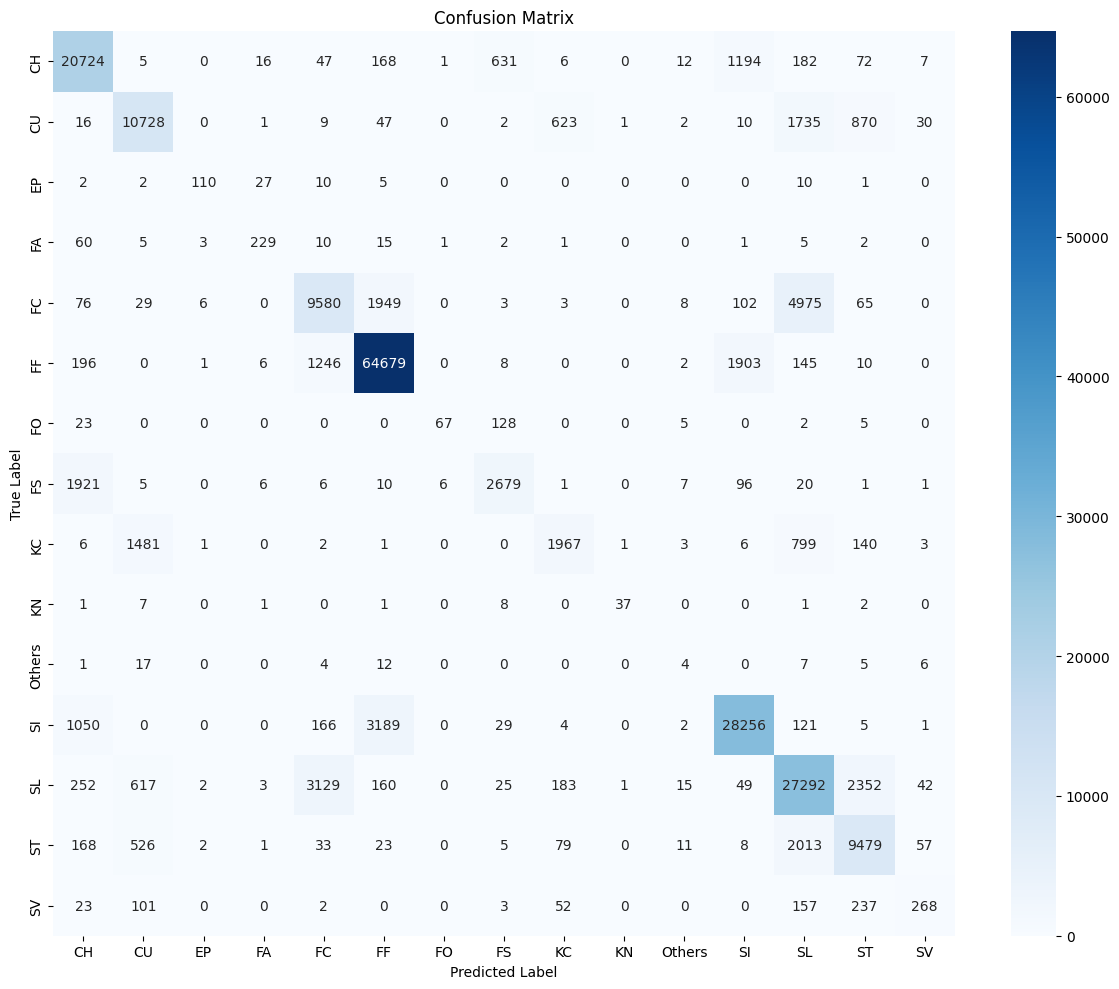

In [24]:
# 混同行列（Confusion Matrix）
cm = confusion_matrix(y_fe_valid, best_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=le_fe.classes_, yticklabels=le_fe.classes_)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()


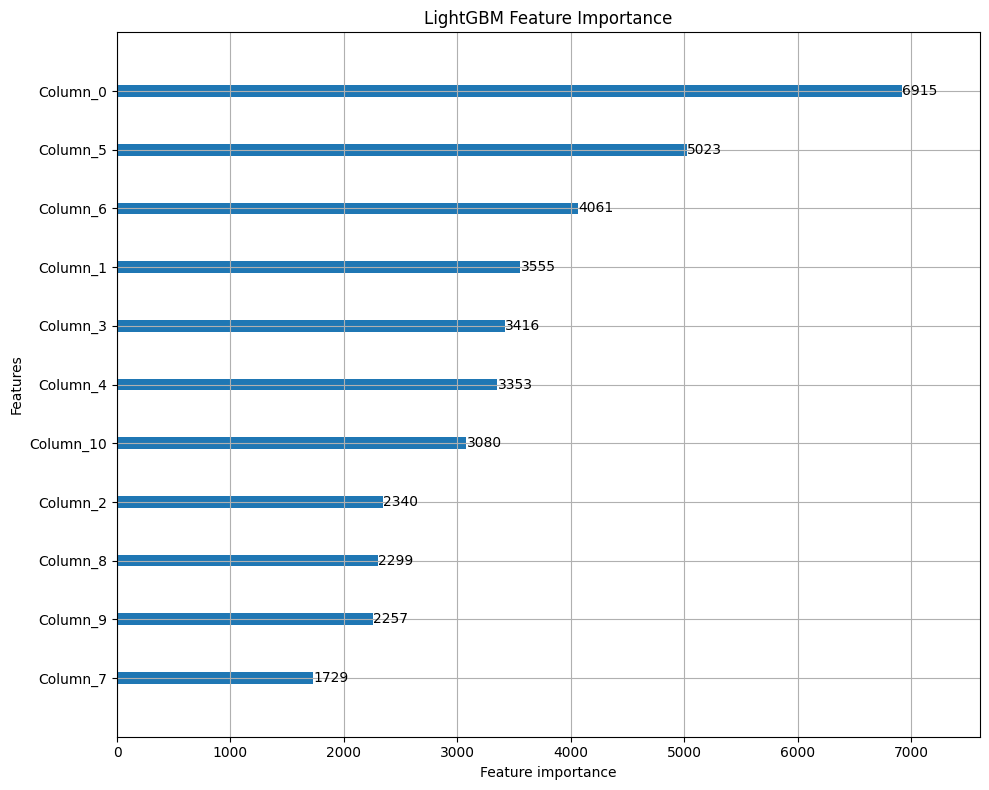

In [25]:
# Feature Importance（特徴量重要度）の可視化 - LightGBM
lgb.plot_importance(lgb_model, figsize=(10, 8), max_num_features=15)
plt.title('LightGBM Feature Importance')
plt.tight_layout()
plt.show()


<Figure size 1000x800 with 0 Axes>

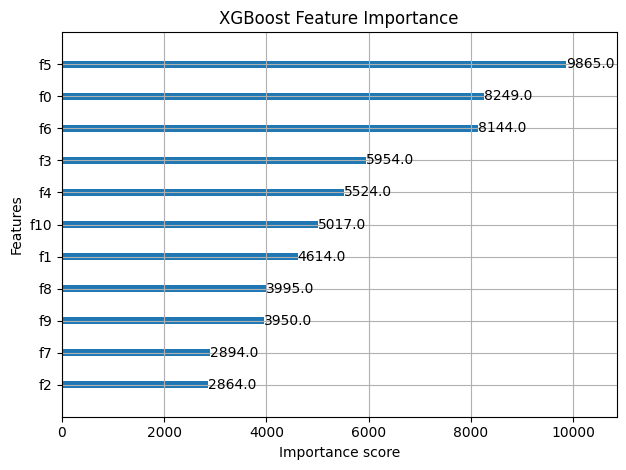

In [26]:
# Feature Importance（特徴量重要度）の可視化 - XGBoost
plt.figure(figsize=(10, 8))
xgb.plot_importance(xgb_model, max_num_features=15)
plt.title('XGBoost Feature Importance')
plt.tight_layout()
plt.show()


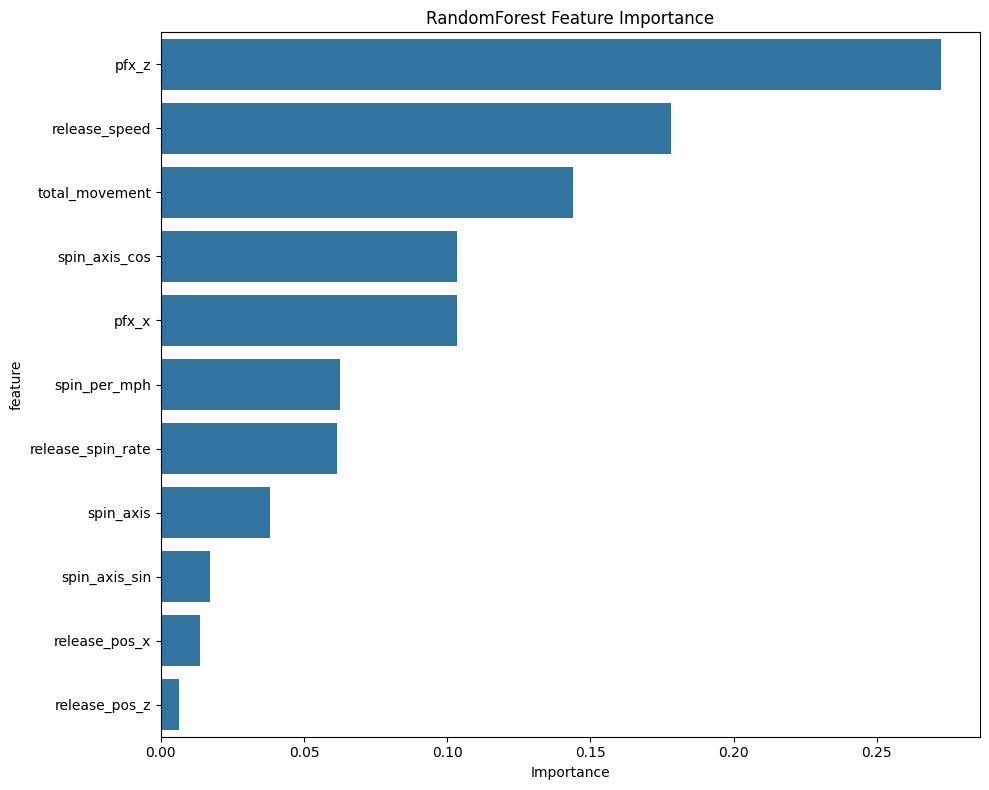

In [27]:
# RandomForestの特徴量重要度
feature_importance = pd.DataFrame({
    'feature': feature_cols_fe,
    'importance': rfc_fe.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(data=feature_importance, x='importance', y='feature')
plt.title('RandomForest Feature Importance')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()


## 7. 結果の分析・Error Analysis

Kaggle流PDCAサイクルの「結果の分析・Error Analysis」フェーズです。

### 分析の目的
- なぜスコアが上がったのか？/ なぜ下がったのか？
- まだ間違えているデータはどれか？
- 次の仮説（特徴量エンジニアリング）のヒントを得る

### 分析の流れ
1. **全体を見る（Global Analysis）**: モデルの「傾向」や「癖」を掴む
2. **個別データを見る（Local Analysis）**: 失敗データから改善のヒントを得る
3. **要因を見る（Feature Analysis）**: なぜその予測をしたのか、判断の根拠を探る

### 7.1 全体を見る（Global Analysis）

まずは森全体を見て、モデルの「傾向」や「癖」を掴みます。

#### 7.1.1 混同行列の確認

「見逃し（False Negative）」が多いのか、「誤検知（False Positive）」が多いのか、特定のクラス間で迷っているのかを特定します。

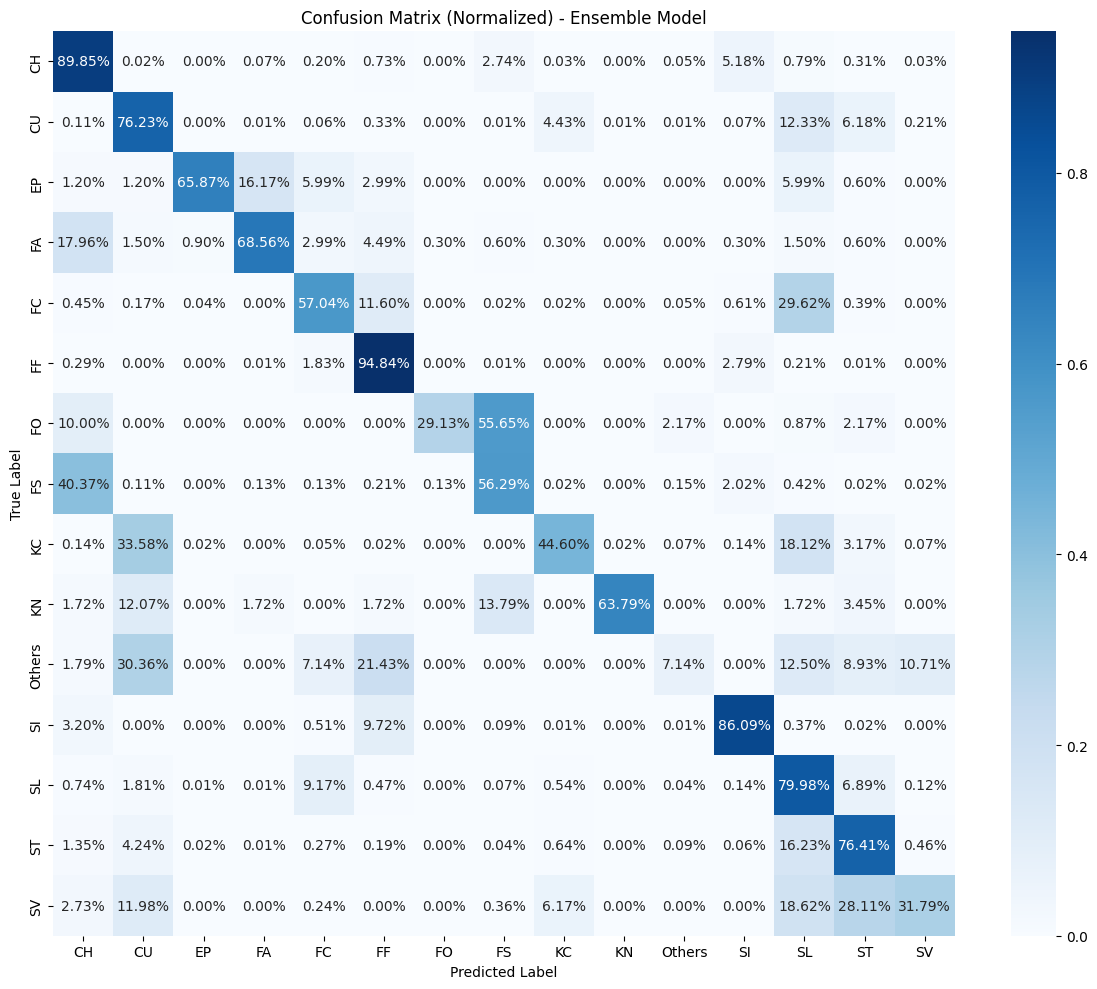


混同行列（数値）:
           CH     CU   EP   FA    FC     FF  FO    FS    KC  KN  Others  \
CH      20724      5    0   16    47    168   1   631     6   0      12   
CU         16  10728    0    1     9     47   0     2   623   1       2   
EP          2      2  110   27    10      5   0     0     0   0       0   
FA         60      5    3  229    10     15   1     2     1   0       0   
FC         76     29    6    0  9580   1949   0     3     3   0       8   
FF        196      0    1    6  1246  64679   0     8     0   0       2   
FO         23      0    0    0     0      0  67   128     0   0       5   
FS       1921      5    0    6     6     10   6  2679     1   0       7   
KC          6   1481    1    0     2      1   0     0  1967   1       3   
KN          1      7    0    1     0      1   0     8     0  37       0   
Others      1     17    0    0     4     12   0     0     0   0       4   
SI       1050      0    0    0   166   3189   0    29     4   0       2   
SL        252 

In [28]:
# 混同行列の可視化（アンサンブルモデル）
from sklearn.metrics import confusion_matrix
import numpy as np

# 予測結果を取得
y_pred_ensemble = ensemble_pred

# 混同行列を計算
cm = confusion_matrix(y_fe_valid, y_pred_ensemble)

# クラス名を取得
class_names = le_fe.classes_

# 混同行列を正規化（パーセンテージ表示）
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# 可視化
plt.figure(figsize=(12, 10))
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix (Normalized) - Ensemble Model')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# 数値の混同行列も表示
print("\n混同行列（数値）:")
print(pd.DataFrame(cm, index=class_names, columns=class_names))

# 各クラスの精度を計算
print("\n各クラスの精度:")
for i, class_name in enumerate(class_names):
    if cm[i, i] > 0:
        if cm[:, i].sum() > 0 and cm[i, :].sum() > 0:
            precision = cm[i, i] / cm[:, i].sum()
            recall = cm[i, i] / cm[i, :].sum()
            print(f"{class_name}: Precision={precision:.3f}, Recall={recall:.3f}")

#### 7.1.2 ROC曲線とAUCの確認

モデルの分類能力の総合力を図ります。多クラス分類のため、各クラスごとにOne-vs-RestでROC曲線を描画します。

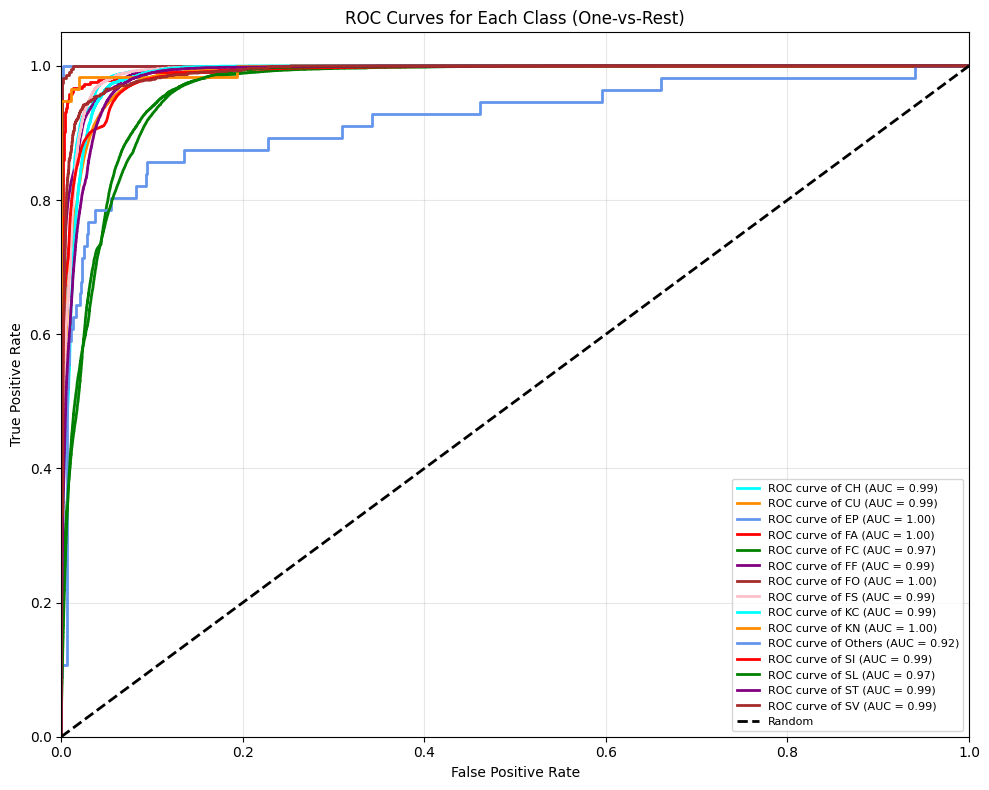


Macro-average AUC: 0.985
Micro-average AUC: 0.993


In [29]:
# ROC曲線とAUCの計算（多クラス分類）
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize
from itertools import cycle

# 予測確率を取得
y_pred_proba_ensemble = ensemble_pred_proba

# ラベルをバイナリ化（One-vs-Rest）
y_valid_binarized = label_binarize(y_fe_valid, classes=range(len(class_names)))
n_classes = len(class_names)

# 各クラスのROC曲線を計算
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_valid_binarized[:, i], y_pred_proba_ensemble[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# マイクロ平均のROC曲線
fpr["micro"], tpr["micro"], _ = roc_curve(y_valid_binarized.ravel(), y_pred_proba_ensemble.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# 可視化
plt.figure(figsize=(10, 8))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'green', 'purple', 'brown', 'pink'])

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of {class_names[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Each Class (One-vs-Rest)')
plt.legend(loc="lower right", fontsize=8)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 平均AUCを表示
macro_auc = np.mean([roc_auc[i] for i in range(n_classes)])
print(f"\nMacro-average AUC: {macro_auc:.3f}")
print(f"Micro-average AUC: {roc_auc['micro']:.3f}")

#### 7.1.3 キャリブレーションの確認

「モデルが出す確率（自信）」と「実際の正解率」が合っているかを確認します。
例：モデルが「確率80%」と予測したデータ群は、実際に10回中8回正解しているか？
これがズレていると、スコア（LogLossなど）が悪化します。

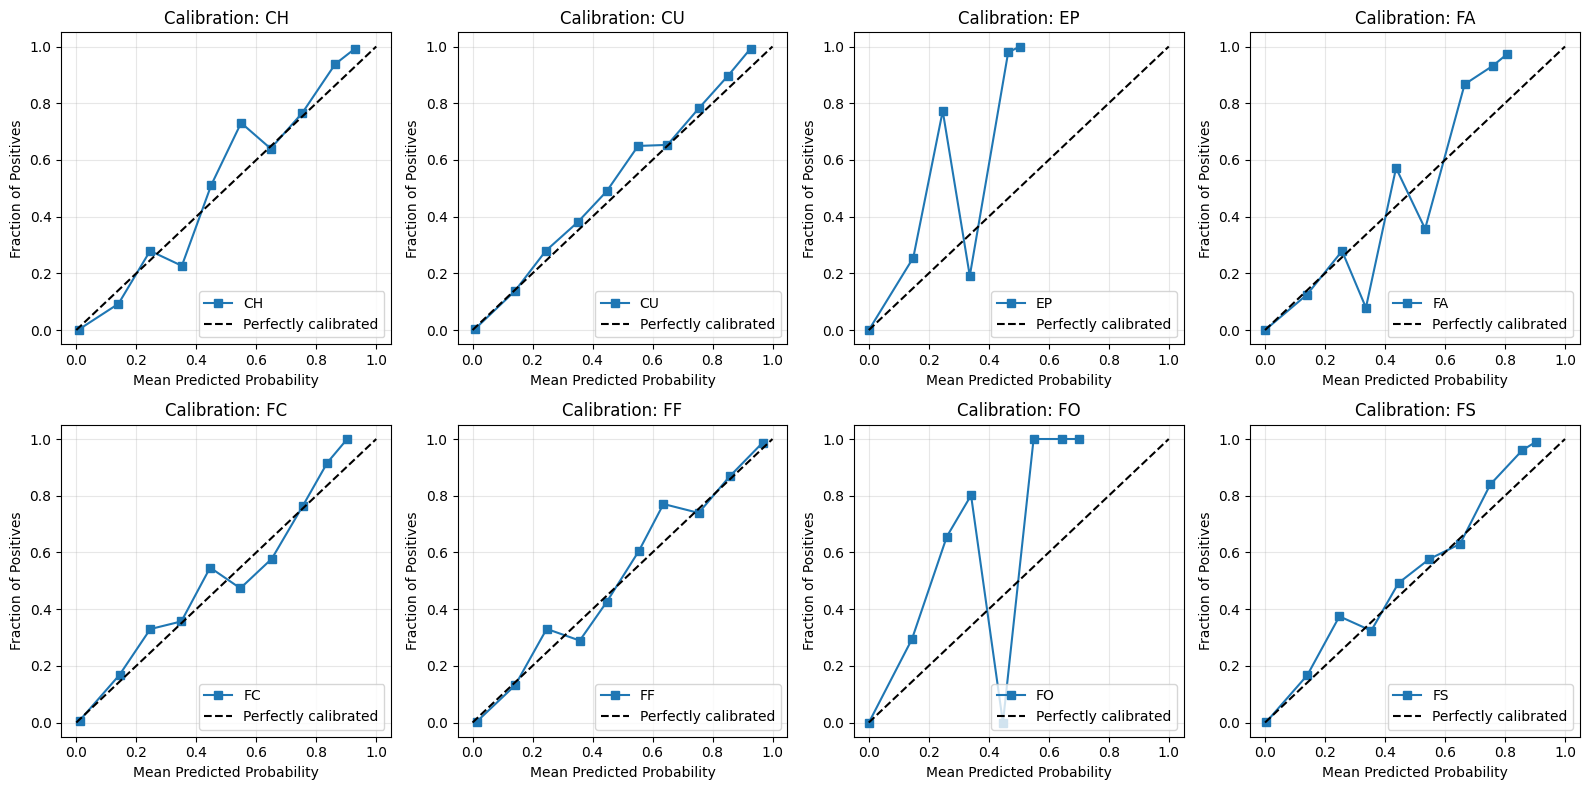

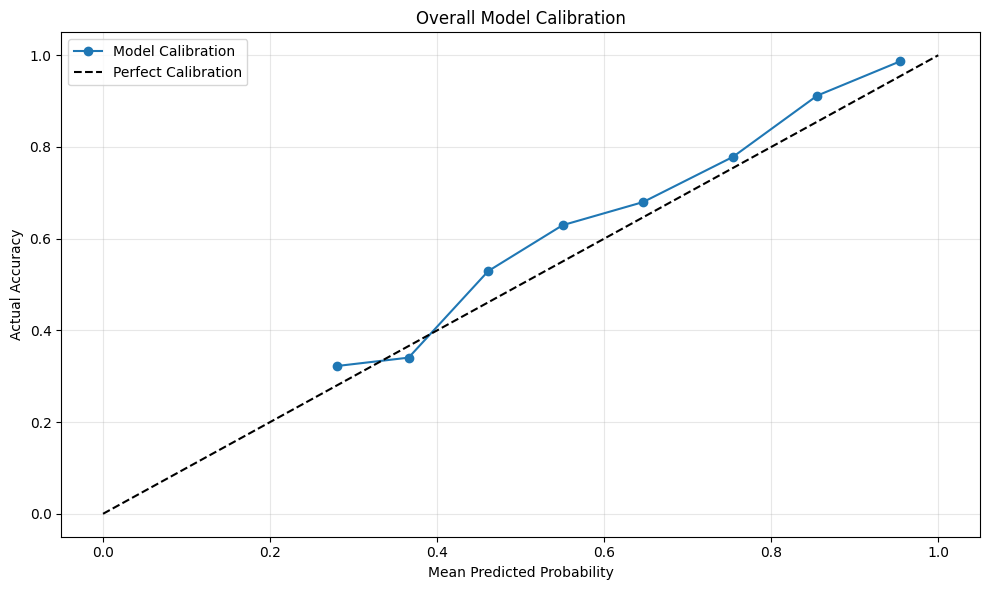

In [30]:
# キャリブレーション曲線の可視化
from sklearn.calibration import calibration_curve

# 各クラスごとにキャリブレーションを確認
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.ravel()

for i, class_name in enumerate(class_names):
    if i < len(axes):
        # そのクラスが正解かどうかのバイナリラベル
        y_true_binary = (y_fe_valid == i).astype(int)
        y_pred_proba_binary = y_pred_proba_ensemble[:, i]
        
        # キャリブレーション曲線を計算
        fraction_of_positives, mean_predicted_value = calibration_curve(
            y_true_binary, y_pred_proba_binary, n_bins=10, strategy='uniform'
        )
        
        # プロット
        axes[i].plot(mean_predicted_value, fraction_of_positives, "s-", label=class_name)
        axes[i].plot([0, 1], [0, 1], "k--", label="Perfectly calibrated")
        axes[i].set_xlabel('Mean Predicted Probability')
        axes[i].set_ylabel('Fraction of Positives')
        axes[i].set_title(f'Calibration: {class_name}')
        axes[i].legend(loc="lower right")
        axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 全体のキャリブレーション（最大確率のクラスが正解かどうか）
max_proba = np.max(y_pred_proba_ensemble, axis=1)
correct = (y_pred_ensemble == y_fe_valid).astype(int)

# 確率の範囲でビン分け
bins = np.linspace(0, 1, 11)
bin_indices = np.digitize(max_proba, bins) - 1
bin_indices = np.clip(bin_indices, 0, len(bins)-2)

# 各ビンの平均確率と正解率を計算
bin_means = []
bin_accuracies = []
for i in range(len(bins)-1):
    mask = bin_indices == i
    if mask.sum() > 0:
        bin_means.append(max_proba[mask].mean())
        bin_accuracies.append(correct[mask].mean())

plt.figure(figsize=(10, 6))
plt.plot(bin_means, bin_accuracies, 'o-', label='Model Calibration')
plt.plot([0, 1], [0, 1], 'k--', label='Perfect Calibration')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Actual Accuracy')
plt.title('Overall Model Calibration')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### 7.2 個別データを見る（Local Analysis / Error Analysis）

ここが最も泥臭く、かつ最も宝（改善のヒント）が埋まっている場所です。

#### 7.2.1 Worst Cases（大失敗）の抽出

予測と正解が最も乖離している（Lossが大きい）データを上位50件ほどリストアップします。
例：正解は「CH」なのに、モデルが「99% FFだ」と予測した投球。

In [31]:
# Worst Casesの抽出
from sklearn.metrics import log_loss

# 各サンプルの損失を計算
sample_losses = []
for i in range(len(y_fe_valid)):
    true_label_idx = y_fe_valid[i]  # y_fe_validはnumpy配列
    true_proba = np.zeros(len(class_names))
    true_proba[true_label_idx] = 1.0
    loss = log_loss([true_proba], [y_pred_proba_ensemble[i]])
    sample_losses.append(loss)

# 損失が大きい順にソート
worst_indices = np.argsort(sample_losses)[::-1][:50]

# Worst Casesの情報をDataFrameにまとめる
worst_cases = []
for idx in worst_indices:
    true_label = class_names[y_fe_valid[idx]]  # y_fe_validはnumpy配列
    pred_label = class_names[y_pred_ensemble[idx]]
    pred_proba = y_pred_proba_ensemble[idx][y_pred_ensemble[idx]]
    loss = sample_losses[idx]
    
    worst_cases.append({
        'index': idx,
        'true_label': true_label,
        'pred_label': pred_label,
        'pred_proba': pred_proba,
        'loss': loss
    })

worst_cases_df = pd.DataFrame(worst_cases)

# 表示
print("Worst Cases (Top 50):")
print(worst_cases_df.head(20))

# 失敗パターンの分析
print("\n失敗パターンの分析:")
print(f"正解ラベル別の失敗数:")
print(worst_cases_df['true_label'].value_counts())
print(f"\n予測ラベル別の失敗数:")
print(worst_cases_df['pred_label'].value_counts())
print(f"\n混同パターン（正解→予測）:")
confusion_pairs = worst_cases_df.groupby(['true_label', 'pred_label']).size().reset_index(name='count')
confusion_pairs = confusion_pairs.sort_values('count', ascending=False)
print(confusion_pairs.head(10))

Worst Cases (Top 50):
     index true_label pred_label  pred_proba      loss
0   138498     Others         FF    0.974858  9.917179
1   139230     Others         FF    0.979484  9.371784
2    60331     Others         FF    0.980430  9.264414
3    25987     Others         FF    0.980860  9.056752
4   167944         KN         FF    0.337486  8.891686
5    56505     Others         FF    0.969996  8.805664
6   140327     Others         FF    0.581461  8.719913
7    41679     Others         FF    0.408891  8.476784
8   189281         SL         FF    0.977480  8.475513
9   201332         FA         SI    0.815583  8.015308
10   10954     Others         FC    0.622012  8.010839
11  112139         FA         FF    0.970766  7.974208
12   48302         FA         CU    0.440926  7.788040
13   83687         SL         FF    0.972503  7.750047
14  171004     Others         FF    0.939295  7.688811
15   25390     Others         FF    0.867225  7.676037
16   53518         FS         SL    0.83661

#### 7.2.2 現物の目視確認（Visual Inspection）

抽出したWorst Casesのデータを詳しく見て、共通点や異常を探します。

**チェックポイント:**
- ラベル間違い（Label Noise）: そもそも正解ラベルが間違っていないか？
- 外れ値: データが壊れている、ノイズが酷すぎるなど
- 欠損情報: 「これ、人間でも判別できないよ」というデータではないか？
- 共通点: 失敗データに共通するパターンはないか？（例：失敗する投球はすべて特定の投手のもの→「投手ID」の特徴量が必要）

In [32]:
# Worst Casesの詳細データを表示
# 元のデータフレームから該当する行を取得
if 'X_fe_valid' in globals():
    # 検証データのインデックスを取得
    valid_indices = X_fe_valid.index if hasattr(X_fe_valid, 'index') else range(len(X_fe_valid))
    
    # Worst Casesの元データを取得
    worst_cases_data = []
    for case in worst_cases[:20]:  # 上位20件を表示
        idx = case['index']
        if isinstance(valid_indices, pd.Index):
            original_idx = valid_indices[idx]
        else:
            original_idx = idx
        
        # 元のデータから該当行を取得（可能な場合）
        if 'data' in globals() and original_idx < len(data):
            row_data = data.iloc[original_idx].to_dict()
            row_data['worst_case_index'] = idx
            row_data['true_label'] = case['true_label']
            row_data['pred_label'] = case['pred_label']
            row_data['pred_proba'] = case['pred_proba']
            row_data['loss'] = case['loss']
            worst_cases_data.append(row_data)
    
    if worst_cases_data:
        worst_cases_detail_df = pd.DataFrame(worst_cases_data)
        print("Worst Casesの詳細データ（上位20件）:")
        print(worst_cases_detail_df[['worst_case_index', 'true_label', 'pred_label', 'pred_proba', 'loss']].head(20))
        
        # 主要な特徴量の統計を表示
        if 'release_speed' in worst_cases_detail_df.columns:
            print("\nWorst Casesの主要特徴量の統計:")
            print(worst_cases_detail_df[['release_speed', 'release_spin_rate', 'pitch_type']].describe())
else:
    print("元のデータフレームにアクセスできません。")
    print("Worst Casesのインデックス:", worst_indices[:20])

# 失敗データの特徴量分布を可視化（成功データと比較）
if 'X_fe_valid' in globals() and len(worst_indices) > 0:
    # 成功データのインデックス（損失が小さい上位50件）
    best_indices = np.argsort(sample_losses)[:50]
    
    # 主要な特徴量を選択（例：release_speed, release_spin_rateなど）
    key_features = ['release_speed', 'release_spin_rate'] if 'release_speed' in X_fe_valid.columns else X_fe_valid.columns[:5]
    
    fig, axes = plt.subplots(1, len(key_features), figsize=(5*len(key_features), 4))
    if len(key_features) == 1:
        axes = [axes]
    
    for i, feat in enumerate(key_features):
        if feat in X_fe_valid.columns:
            worst_values = X_fe_valid.iloc[worst_indices[:50]][feat] if hasattr(X_fe_valid, 'iloc') else X_fe_valid[worst_indices[:50]][feat]
            best_values = X_fe_valid.iloc[best_indices[:50]][feat] if hasattr(X_fe_valid, 'iloc') else X_fe_valid[best_indices[:50]][feat]
            
            axes[i].hist(worst_values, alpha=0.5, label='Worst Cases', bins=20)
            axes[i].hist(best_values, alpha=0.5, label='Best Cases', bins=20)
            axes[i].set_xlabel(feat)
            axes[i].set_ylabel('Frequency')
            axes[i].set_title(f'Distribution: {feat}')
            axes[i].legend()
    
    plt.tight_layout()
    plt.show()

Worst Casesの詳細データ（上位20件）:
    worst_case_index true_label pred_label  pred_proba      loss
0             138498     Others         FF    0.974858  9.917179
1             139230     Others         FF    0.979484  9.371784
2              60331     Others         FF    0.980430  9.264414
3              25987     Others         FF    0.980860  9.056752
4             167944         KN         FF    0.337486  8.891686
5              56505     Others         FF    0.969996  8.805664
6             140327     Others         FF    0.581461  8.719913
7              41679     Others         FF    0.408891  8.476784
8             189281         SL         FF    0.977480  8.475513
9             201332         FA         SI    0.815583  8.015308
10             10954     Others         FC    0.622012  8.010839
11            112139         FA         FF    0.970766  7.974208
12             48302         FA         CU    0.440926  7.788040
13             83687         SL         FF    0.972503  7.750047

AttributeError: 'numpy.ndarray' object has no attribute 'columns'

### 7.3 要因を見る（Feature Analysis）

なぜモデルはその予測をしたのか、判断の根拠を探ります。

#### 7.3.1 Feature Importance（特徴量重要度）の詳細分析

既に可視化したFeature Importanceを、より詳細に分析します。

In [ ]:
# 各モデルの特徴量重要度を比較
lgb_importance = pd.DataFrame({
    'feature': feature_cols_fe,
    'lgb_importance': lgb_model.feature_importances_
}).sort_values('lgb_importance', ascending=False)

xgb_importance = pd.DataFrame({
    'feature': feature_cols_fe,
    'xgb_importance': xgb_model.feature_importances_
}).sort_values('xgb_importance', ascending=False)

rfc_importance = pd.DataFrame({
    'feature': feature_cols_fe,
    'rfc_importance': rfc_fe.feature_importances_
}).sort_values('rfc_importance', ascending=False)

# マージして比較
importance_comparison = lgb_importance.merge(xgb_importance, on='feature').merge(rfc_importance, on='feature')
importance_comparison['avg_importance'] = (
    importance_comparison['lgb_importance'] + 
    importance_comparison['xgb_importance'] + 
    importance_comparison['rfc_importance']
) / 3
importance_comparison = importance_comparison.sort_values('avg_importance', ascending=False)

print("特徴量重要度の比較（上位20件）:")
print(importance_comparison.head(20))

# 可視化
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# LightGBM
axes[0, 0].barh(range(15), lgb_importance['lgb_importance'].head(15))
axes[0, 0].set_yticks(range(15))
axes[0, 0].set_yticklabels(lgb_importance['feature'].head(15))
axes[0, 0].set_xlabel('Importance')
axes[0, 0].set_title('LightGBM Top 15 Features')

# XGBoost
axes[0, 1].barh(range(15), xgb_importance['xgb_importance'].head(15))
axes[0, 1].set_yticks(range(15))
axes[0, 1].set_yticklabels(xgb_importance['feature'].head(15))
axes[0, 1].set_xlabel('Importance')
axes[0, 1].set_title('XGBoost Top 15 Features')

# RandomForest
axes[1, 0].barh(range(15), rfc_importance['rfc_importance'].head(15))
axes[1, 0].set_yticks(range(15))
axes[1, 0].set_yticklabels(rfc_importance['feature'].head(15))
axes[1, 0].set_xlabel('Importance')
axes[1, 0].set_title('RandomForest Top 15 Features')

# 平均重要度
axes[1, 1].barh(range(15), importance_comparison['avg_importance'].head(15))
axes[1, 1].set_yticks(range(15))
axes[1, 1].set_yticklabels(importance_comparison['feature'].head(15))
axes[1, 1].set_xlabel('Average Importance')
axes[1, 1].set_title('Average Importance (All Models) Top 15')

plt.tight_layout()
plt.show()

# 重要度が低い特徴量を確認（削除候補）
print("\n重要度が低い特徴量（下位10件）:")
print(importance_comparison.tail(10))

#### 7.3.2 SHAP値の分析（推奨）

Feature Importanceの上位互換的な分析手法です。「その特徴量が予測値をプラスに動かしたか、マイナスに動かしたか」まで分かります。

例：「球速」が高いほど、ある球種の予測確率が「上がる」という関係が見える。
これが直感（ドメイン知識）と反している場合、データ処理かモデルの学習にバグがある可能性があります。

**注意**: SHAPライブラリがインストールされていない場合は、`pip install shap` を実行してください。

In [ ]:
# SHAP値の計算と可視化
try:
    import shap
    
    # SHAP値を計算（サンプル数を制限して計算時間を短縮）
    sample_size = min(100, len(X_fe_valid))
    sample_indices = np.random.choice(len(X_fe_valid), sample_size, replace=False)
    X_sample = X_fe_valid.iloc[sample_indices] if hasattr(X_fe_valid, 'iloc') else X_fe_valid[sample_indices]
    
    # LightGBMモデルでSHAP値を計算
    explainer = shap.TreeExplainer(lgb_model)
    shap_values = explainer.shap_values(X_sample)
    
    # 各クラスごとのSHAP値を可視化（最初のクラスのみ）
    if isinstance(shap_values, list):
        class_idx = 0
        shap_values_class = shap_values[class_idx]
    else:
        shap_values_class = shap_values
    
    # Summary plot（全体の傾向）
    plt.figure(figsize=(12, 8))
    shap.summary_plot(shap_values_class, X_sample, plot_type="bar", show=False)
    plt.title(f'SHAP Summary Plot (Class: {class_names[0]})')
    plt.tight_layout()
    plt.show()
    
    # 個別サンプルのSHAP値を可視化（最初の5サンプル）
    for i in range(min(5, len(X_sample))):
        plt.figure(figsize=(10, 6))
        if isinstance(shap_values, list):
            shap.waterfall_plot(shap.Explanation(
                values=shap_values[y_fe_valid[sample_indices[i]]],  # y_fe_validはnumpy配列
                base_values=explainer.expected_value[y_fe_valid[sample_indices[i]]] if isinstance(explainer.expected_value, list) else explainer.expected_value,
                data=X_sample.iloc[i] if hasattr(X_sample, 'iloc') else X_sample[i],
                feature_names=feature_cols_fe
            ), show=False)
        plt.title(f'Sample {i} SHAP Values')
        plt.tight_layout()
        plt.show()
    
    print("SHAP値の分析が完了しました。")
    
except ImportError:
    print("SHAPライブラリがインストールされていません。")
    print("インストールするには: pip install shap")
    print("\n代替として、部分依存プロット（Partial Dependence Plot）を表示します。")
    
    # 部分依存プロット（代替）
    from sklearn.inspection import PartialDependenceDisplay
    
    # 主要な特徴量を選択
    top_features = importance_comparison.head(5)['feature'].tolist()
    
    fig, axes = plt.subplots(1, len(top_features), figsize=(5*len(top_features), 4))
    if len(top_features) == 1:
        axes = [axes]
    
    for i, feat in enumerate(top_features):
        if feat in X_fe_valid.columns:
            feat_idx = list(X_fe_valid.columns).index(feat)
            display = PartialDependenceDisplay.from_estimator(
                lgb_model, X_fe_valid, [feat_idx], 
                ax=axes[i], feature_names=feature_cols_fe
            )
            axes[i].set_title(f'Partial Dependence: {feat}')
    
    plt.tight_layout()
    plt.show()

### 7.4 分析結果のまとめと次の仮説

このフェーズを終えるとき、手元に以下の「次の仮説」が揃っている状態を目指してください。

#### チェックリスト

- [ ] **データの修正**: 「この外れ値データは学習に悪影響なので削除しよう」
- [ ] **特徴量の追加**: 「失敗データは〇〇という傾向があるから、それを数値化する新しい特徴量を作ろう」
- [ ] **モデルの変更**: 「このモデルは線形な関係を捉えられていないから、ニューラルネットも試そう」
- [ ] **前処理の変更**: 「外れ値に引っ張られているから、対数変換して分布を整えよう」

#### 次のステップ

1. 分析結果を基に、新しい特徴量を設計
2. 前処理方法を見直す
3. モデルのハイパーパラメータを調整
4. 新しいモデルを試す
5. Local CVで検証
6. 結果が改善したら、再度このError Analysisを実行